In [1]:
model_name = 'FastSCNN_lr_dynamic_batch_2_standard_scale_[1.0, 1.1]_colour_0.25_blur_0.03_linearup_weightedloss_wd_1e-7'

In [2]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from tqdm import tqdm
import json  # To save and read mean and std values as JSON

# Directory containing your training images
image_directory = 'train/train_image'

# Transform to convert the images to a tensor
transform = transforms.ToTensor()

# Path to store the mean and std
stats_file_path = 'mean_std.json'

# Function to calculate mean and std
def calculate_mean_std():
    mean = torch.zeros(3)
    std = torch.zeros(3)
    num_pixels = 0

    # Iterate through each image in the directory
    for image_name in tqdm(os.listdir(image_directory)):
        image_path = os.path.join(image_directory, image_name)
        image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
        image_tensor = transform(image)
        
        # Accumulate sum and sum of squares for mean and std calculation
        mean += image_tensor.mean(dim=(1, 2))
        std += image_tensor.std(dim=(1, 2))
        num_pixels += 1

    # Compute the mean and std for each channel
    mean /= num_pixels
    std /= num_pixels

    # Convert to standard Python float types for saving to JSON
    mean_list = mean.tolist()
    std_list = std.tolist()

    # Save to a file
    stats = {'mean': mean_list, 'std': std_list}
    with open(stats_file_path, 'w') as f:
        json.dump(stats, f)
    print(f'Saved mean and std to {stats_file_path}')

    return mean, std

# Check if mean and std are already saved in the file
if os.path.exists(stats_file_path):
    print(f'{stats_file_path} found, loading mean and std...')
    with open(stats_file_path, 'r') as f:
        stats = json.load(f)
        mean = torch.tensor(stats['mean'])
        std = torch.tensor(stats['std'])
    print(f'Mean: {mean}')
    print(f'Std: {std}')
else:
    print(f'{stats_file_path} not found, calculating mean and std...')
    mean, std = calculate_mean_std()

print(f'Final Mean: {mean}')
print(f'Final Std: {std}')

mean_std.json found, loading mean and std...
Mean: tensor([0.5192, 0.4182, 0.3640])
Std: tensor([0.2684, 0.2415, 0.2340])
Final Mean: tensor([0.5192, 0.4182, 0.3640])
Final Std: tensor([0.2684, 0.2415, 0.2340])


In [3]:
import random

# Set the random seed for reproducibility
seed = 42 # This is the answer to the ultimate question of life, the universe and everything
np.random.seed(seed)
random.seed(seed)

In [4]:
import torchvision.transforms.functional as F1
from torchvision import transforms
import random
import numpy as np
import torch

class JointTransform:
    def __init__( 
        self, resize=(512, 512), rotation_degree=15, scale=(0.9, 1.1), 
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, gaussian_noise_std=0.01,
        apply_gaussian_blur=False, blur_kernel_size=3, mean=(0.4914, 0.4822, 0.4465), 
        std=(0.2023, 0.1994, 0.2010)
    ):
        self.resize = resize
        self.rotation_degree = rotation_degree
        self.scale = scale
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.gaussian_noise_std = gaussian_noise_std
        self.apply_gaussian_blur = apply_gaussian_blur
        self.blur_kernel_size = blur_kernel_size
        self.mean = mean
        self.std = std

    def __call__(self, image, mask):
        # Resize
        image = F1.resize(image, self.resize)
        mask = F1.resize(mask, self.resize, interpolation=Image.NEAREST)

    
        # # Random Rotation (Only if rotation_degree > 0)
        # if self.rotation_degree > 0:
        #     angle = random.uniform(-self.rotation_degree, self.rotation_degree)
        #     image = F1.rotate(image, angle)
        #     mask = F1.rotate(mask, angle)
        
        # Random Scaling
        scale_factor = random.uniform(self.scale[0], self.scale[1])
        new_size = [int(self.resize[0] * scale_factor), int(self.resize[1] * scale_factor)]
        image = F1.resize(image, new_size)
        mask = F1.resize(mask, new_size, interpolation=Image.NEAREST)
        
        # Center Crop to Original Size
        image = F1.center_crop(image, self.resize)
        mask = F1.center_crop(mask, self.resize)
        
        # Color Jitter
        color_jitter = transforms.ColorJitter(
            brightness=self.brightness, 
            contrast=self.contrast, 
            saturation=self.saturation, 
            hue=self.hue
        )
        image = color_jitter(image)
        
        # Gaussian Blur
        if self.apply_gaussian_blur and random.random() < 0.5:
            image = F1.gaussian_blur(image, kernel_size=self.blur_kernel_size)
        
        # Convert to tensor
        image = F1.to_tensor(image)
        mask = F1.pil_to_tensor(mask).squeeze(0).long()
        
        # Add Gaussian Noise
        if self.gaussian_noise_std > 0:
            noise = torch.randn(image.size()) * self.gaussian_noise_std
            image = image + noise
            
        # Clamp image values to [0, 1] after adding noise
        image = torch.clamp(image, 0.0, 1.0)
        
        # Normalize the image
        image = F1.normalize(image, mean=self.mean, std=self.std)
        
        return image, mask

In [5]:
# Define transforms
train_transform = JointTransform(
    resize=(512, 512), rotation_degree=0, scale=(1.0, 1.1),
    brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1,
    gaussian_noise_std=0.03, apply_gaussian_blur=True, blur_kernel_size=3,
    mean=mean, std=std
)
val_transform = JointTransform(
    resize=(512, 512), rotation_degree=0, scale=(1.0, 1.0),
    brightness=0.0, contrast=0.0, saturation=0.0, hue=0.0,
    gaussian_noise_std=0.0, apply_gaussian_blur=False, blur_kernel_size=0,
    mean=mean, std=std
)

In [6]:
import torch
import torchvision.transforms.functional as F1
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class CelebAMaskHQDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_ext='jpg', mask_ext='png', transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [file for file in os.listdir(image_dir) if file.endswith(f'.{image_ext}')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '.png'))

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # Apply transforms
        if self.transform:
            image, mask = self.transform(image, mask)
        else:
            image = F1.to_tensor(image)
            mask = F1.pil_to_tensor(mask).squeeze(0).long()
        
        return image, mask

# Load training dataset with augmentation
train_dataset = CelebAMaskHQDataset(
    image_dir='train/train_image', 
    mask_dir='train/train_mask', 
    image_ext='jpg', mask_ext='png', 
    transform=train_transform
)

# # Load training dataset with augmentation TINY
# train_dataset = CelebAMaskHQDataset(
#     image_dir='train_tiny/train_image', 
#     mask_dir='train_tiny/train_mask', 
#     image_ext='jpg', mask_ext='png', 
#     transform=train_transform
# )

# Load validation dataset without augmentation
val_dataset = CelebAMaskHQDataset(
    image_dir='val/val_image', 
    mask_dir='val/val_mask', 
    image_ext='jpg', mask_ext='png', 
    transform=val_transform
)

# Create DataLoaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, pin_memory=True)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dataset(loader, num_examples=5):
    # Get one batch of data
    dataiter = iter(loader)
    images, masks = next(dataiter)
    
    # Ensure the number of examples does not exceed the batch size
    num_examples = min(num_examples, images.size(0))
    
    # Convert tensors to NumPy arrays for plotting
    images = images.numpy()
    masks = masks.numpy()
    
    for idx in range(num_examples):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        
        # Image
        img = images[idx].transpose(1, 2, 0)  # (C, H, W) to (H, W, C)
        img = np.clip(img, 0, 1)  # Ensure values are between 0 and 1
        ax[0].imshow(img)
        ax[0].set_title('Image')
        ax[0].axis('off')
        
        # Mask
        mask = masks[idx]
        ax[1].imshow(mask, cmap='jet', interpolation='nearest')
        ax[1].set_title('Mask')
        ax[1].axis('off')
        
        plt.tight_layout()
        plt.show()

Training examples:


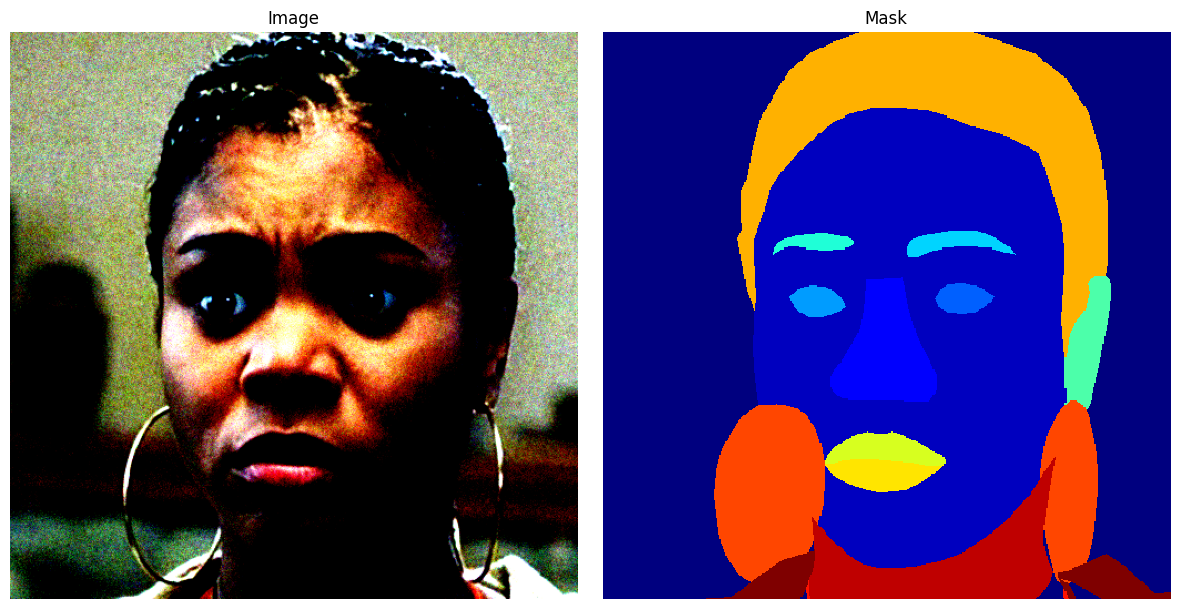

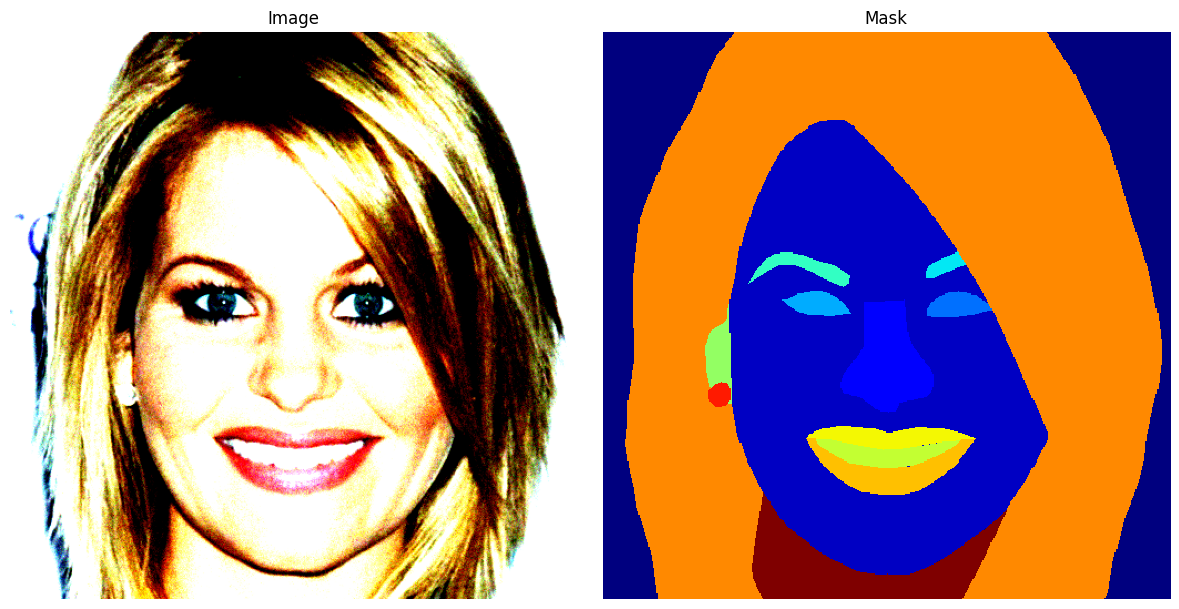

In [8]:
print("Training examples:")
visualize_dataset(train_loader, num_examples=10)

Validation examples:


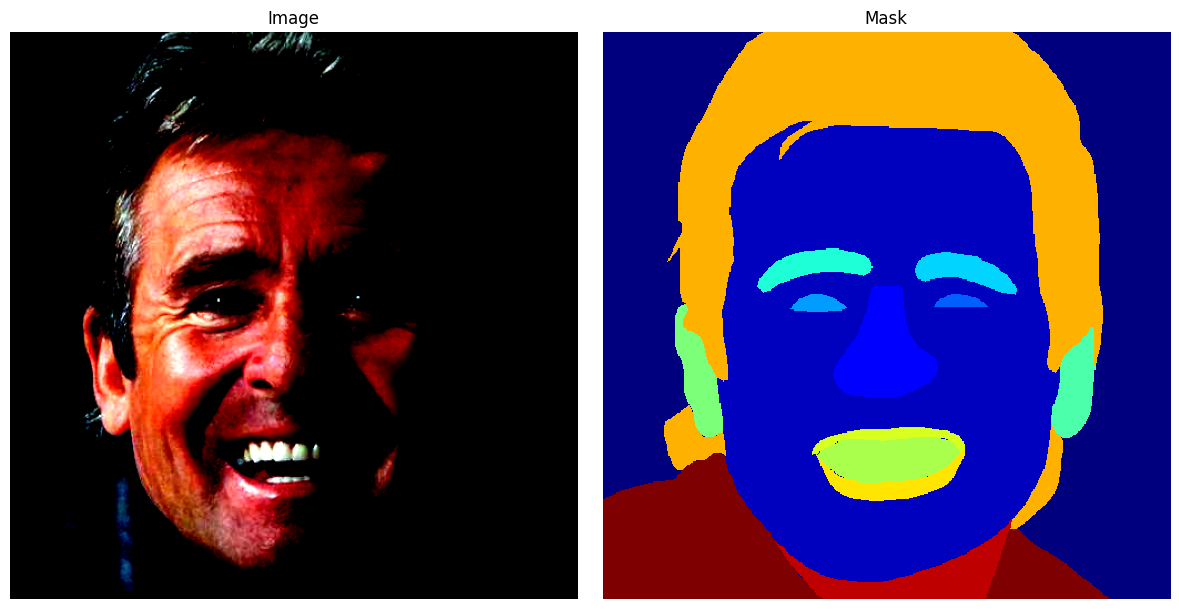

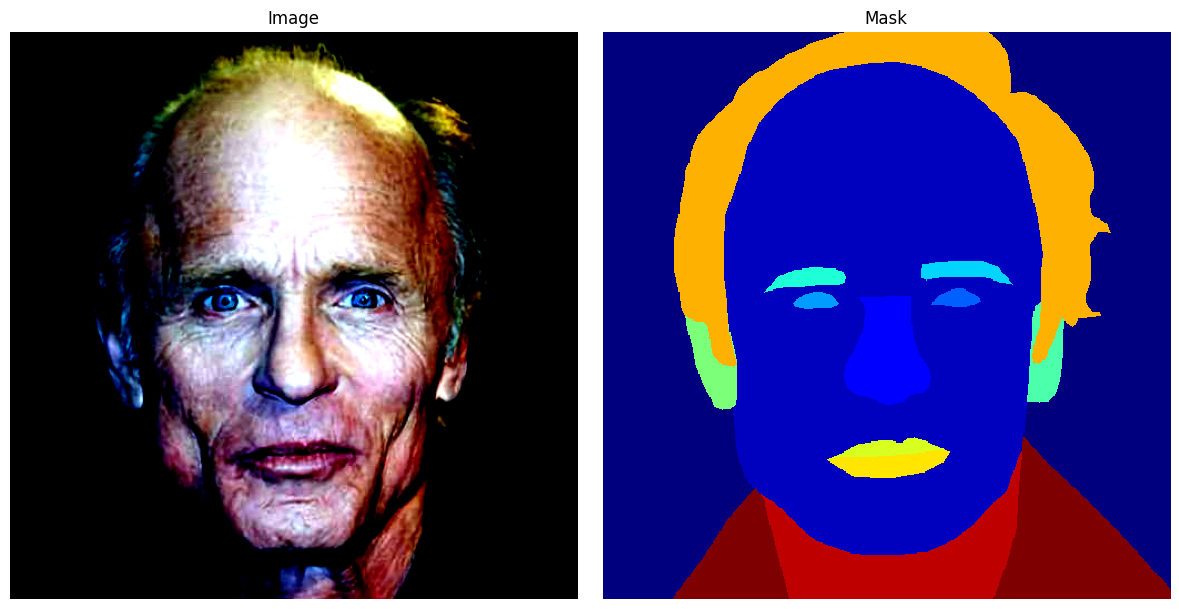

In [9]:
print("Validation examples:")
visualize_dataset(val_loader, num_examples=10)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class _ConvBNReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
        super(_ConvBNReLU, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False, groups=groups),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

class _DWConv(nn.Sequential):
    def __init__(self, dw_channels, out_channels, stride=1):
        super(_DWConv, self).__init__(
            # Depthwise convolution
            nn.Conv2d(dw_channels, dw_channels, kernel_size=3, stride=stride, padding=1, groups=dw_channels, bias=False),
            nn.BatchNorm2d(dw_channels),
            nn.ReLU(inplace=True),
            # Pointwise convolution
            nn.Conv2d(dw_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

class LearningToDownsample(nn.Module):
    def __init__(self, in_channels=3, dw_channels1=32, dw_channels2=48, out_channels=64):
        super(LearningToDownsample, self).__init__()
        self.conv = _ConvBNReLU(in_channels, dw_channels1, 3, 2, 1)
        self.dsconv1 = _DWConv(dw_channels1, dw_channels2, stride=2)
        self.dsconv2 = _DWConv(dw_channels2, out_channels, stride=2)
    def forward(self, x):
        x = self.conv(x)
        x = self.dsconv1(x)
        x = self.dsconv2(x)
        return x

class GlobalFeatureExtractor(nn.Module):
    def __init__(self, in_channels=64, block_channels=[64, 96, 128], out_channels=128, num_blocks=3, expansion_factor=6):
        super(GlobalFeatureExtractor, self).__init__()
        self.bottleneck1 = self._make_layer(in_channels, block_channels[0], num_blocks, expansion_factor, stride=2)
        self.bottleneck2 = self._make_layer(block_channels[0], block_channels[1], num_blocks, expansion_factor, stride=2)
        self.bottleneck3 = self._make_layer(block_channels[1], block_channels[2], num_blocks, expansion_factor, stride=1)
        self.ppm = PyramidPooling(block_channels[2], out_channels)
    def _make_layer(self, in_channels, out_channels, blocks, expansion_factor, stride):
        layers = []
        layers.append(Bottleneck(in_channels, out_channels, expansion_factor, stride))
        for _ in range(1, blocks):
            layers.append(Bottleneck(out_channels, out_channels, expansion_factor, 1))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.bottleneck1(x)
        x = self.bottleneck2(x)
        x = self.bottleneck3(x)
        x = self.ppm(x)
        return x

class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor, stride):
        super(Bottleneck, self).__init__()
        mid_channels = in_channels * expansion_factor
        self.use_res_connect = stride == 1 and in_channels == out_channels
        self.conv = nn.Sequential(
            # Pointwise convolution
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            # Depthwise convolution
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            # Linear pointwise convolution
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class PyramidPooling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PyramidPooling, self).__init__()
        pool_sizes = [1, 2, 3, 6]
        mid_channels = int(in_channels / len(pool_sizes))
        self.stages = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=ps),
                _ConvBNReLU(in_channels, mid_channels, kernel_size=1, stride=1, padding=0)
            ) for ps in pool_sizes
        ])
        self.bottleneck = _ConvBNReLU(in_channels + mid_channels * len(pool_sizes), out_channels, kernel_size=1, stride=1, padding=0)
    def forward(self, x):
        h, w = x.size()[2:]
        pyramids = [x]
        for stage in self.stages:
            out = stage(x)
            out = F.interpolate(out, size=(h, w), mode='bilinear', align_corners=True)
            pyramids.append(out)
        output = torch.cat(pyramids, dim=1)
        output = self.bottleneck(output)
        return output

class FeatureFusionModule(nn.Module):
    """Feature fusion module"""

    def __init__(self, high_channels, low_channels, out_channels, scale_factor=4):
        super(FeatureFusionModule, self).__init__()
        self.scale_factor = scale_factor

        # Depthwise separable convolution on low-resolution features
        self.dwconv_low = nn.Sequential(
            nn.Conv2d(low_channels, low_channels, kernel_size=3, stride=1, padding=1, groups=low_channels, bias=False),
            nn.BatchNorm2d(low_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(low_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # 1x1 convolution on high-resolution features
        self.conv_high = nn.Sequential(
            nn.Conv2d(high_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # Additional layers after fusion
        self.fusion = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, high_res_feature, low_res_feature):
        # Upsample low-resolution feature
        low_res_feature = F.interpolate(low_res_feature, scale_factor=self.scale_factor, mode='bilinear', align_corners=True)
        low_res_feature = self.dwconv_low(low_res_feature)
        high_res_feature = self.conv_high(high_res_feature)
        # Fuse features
        fused_feature = high_res_feature + low_res_feature
        fused_feature = self.fusion(fused_feature)
        return self.relu(fused_feature)

class Classifier(nn.Sequential):
    def __init__(self, dw_channels, num_classes):
        super(Classifier, self).__init__(
            _DWConv(dw_channels, dw_channels),
            _DWConv(dw_channels, dw_channels),
            nn.Dropout(0.1),
            nn.Conv2d(dw_channels, num_classes, kernel_size=1, stride=1, padding=0)
        )

class FastSCNN(nn.Module):
    def __init__(self, num_classes=19, in_channels=3):
        super(FastSCNN, self).__init__()
        self.learning_to_downsample = LearningToDownsample(in_channels, dw_channels1=32, dw_channels2=48, out_channels=64)
        self.global_feature_extractor = GlobalFeatureExtractor(in_channels=64, block_channels=[64, 96, 128], out_channels=128, num_blocks=3, expansion_factor=6)
        self.feature_fusion = FeatureFusionModule(high_channels=64, low_channels=128, out_channels=128)
        self.classifier = Classifier(dw_channels=128, num_classes=num_classes)
    def forward(self, x):
        size = x.size()[2:]
        higher_res_features = self.learning_to_downsample(x)
        low_res_features = self.global_feature_extractor(higher_res_features)
        fused_features = self.feature_fusion(higher_res_features, low_res_features)
        x = self.classifier(fused_features)
        x = F.interpolate(x, size=size, mode='bilinear', align_corners=True)
        return x

In [11]:
# Check if CUDA is available
if torch.cuda.is_available():

    # Get the number of GPUs
    num_gpus = torch.cuda.device_count()

    # Print each GPU's index and name
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

GPU 0: NVIDIA A30
GPU 1: NVIDIA A30
GPU 2: NVIDIA A30
GPU 3: NVIDIA A30


In [12]:
# Instantiate the model
num_classes = 19  # Replace with the number of classes in your dataset

# Specify a specific GPU (e.g., GPU 2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create a model instance
model = FastSCNN(num_classes=num_classes, in_channels=3)

model.to(device)

FastSCNN(
  (learning_to_downsample): LearningToDownsample(
    (conv): _ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (dsconv1): _DWConv(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (dsconv2): _DWConv(
      (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=48, bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3):

In [13]:
# Count the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 1154435


In [14]:
import torch
import torch.nn as nn
import os
import json
from tqdm import tqdm

# File to save/load class distribution
class_dist_file_path = 'class_distribution.json'

# Function to compute class distribution
def calculate_class_distribution(train_loader, num_classes=19):
    # Initialize an empty tensor to hold the count of pixels for each of the classes
    class_distribution = torch.zeros(num_classes, dtype=torch.long)

    # Iterate through all batches in the train loader
    for images, masks in tqdm(train_loader):  # Assuming masks are (batch_size, H, W) with integer class labels
        # Flatten masks to count pixels across all batches and images
        flattened_masks = masks.view(-1)  # (batch_size * H * W,)
        
        # Update class distribution by counting occurrences of each class (0 to num_classes-1)
        for class_idx in range(num_classes):
            class_distribution[class_idx] += (flattened_masks == class_idx).sum().item()

    # Convert to a list for saving
    class_distribution_list = class_distribution.tolist()

    # Save the class distribution to a JSON file
    with open(class_dist_file_path, 'w') as f:
        json.dump({'class_distribution': class_distribution_list}, f)

    print(f'Saved class distribution to {class_dist_file_path}')

    return class_distribution

# Check if class distribution file already exists
if os.path.exists(class_dist_file_path):
    print(f'{class_dist_file_path} found, loading class distribution...')
    with open(class_dist_file_path, 'r') as f:
        class_dist_data = json.load(f)
        class_distribution = torch.tensor(class_dist_data['class_distribution'], dtype=torch.long)
    print(f'Loaded class distribution: {class_distribution}')
else:
    print(f'{class_dist_file_path} not found, calculating class distribution...')
    class_distribution = calculate_class_distribution(train_loader, num_classes=19)

# Print out the pixel distribution across the 19 classes
for class_idx in range(19):
    print(f"Class {class_idx}: {class_distribution[class_idx]} pixels")

# Now we compute the class weights dynamically based on class_distribution
total_pixels = class_distribution.sum().item()  # Total number of pixels across all classes

# Calculate class frequencies
class_frequencies = class_distribution.float()

# Add a small epsilon to avoid taking the log of zero
epsilon = 1e-6
class_weights = 1.0 / torch.log(class_frequencies + epsilon)

# Normalise the weights to sum to 1 (optional)
class_weights = class_weights / class_weights.sum()

# Print the computed class weights
for class_idx in range(19):
    print(f"Weight for Class {class_idx}: {class_weights[class_idx].item()}")

# Assuming you are using CUDA, move the class weights to the device
class_weights = class_weights.to(device)

class_distribution.json found, loading class distribution...
Loaded class distribution: tensor([334569754, 366476508,  29768393,   3817615,   3226296,   3216846,
          6134387,   5979756,   6571838,   5410441,   4282205,   5970598,
          9800294, 421035925,  13123461,   3329644,    167697,  48808331,
         39030011])
Class 0: 334569754 pixels
Class 1: 366476508 pixels
Class 2: 29768393 pixels
Class 3: 3817615 pixels
Class 4: 3226296 pixels
Class 5: 3216846 pixels
Class 6: 6134387 pixels
Class 7: 5979756 pixels
Class 8: 6571838 pixels
Class 9: 5410441 pixels
Class 10: 4282205 pixels
Class 11: 5970598 pixels
Class 12: 9800294 pixels
Class 13: 421035925 pixels
Class 14: 13123461 pixels
Class 15: 3329644 pixels
Class 16: 167697 pixels
Class 17: 48808331 pixels
Class 18: 39030011 pixels
Weight for Class 0: 0.04310351237654686
Weight for Class 1: 0.042904406785964966
Weight for Class 2: 0.04916341230273247
Weight for Class 3: 0.05582603067159653
Weight for Class 4: 0.0564529150724

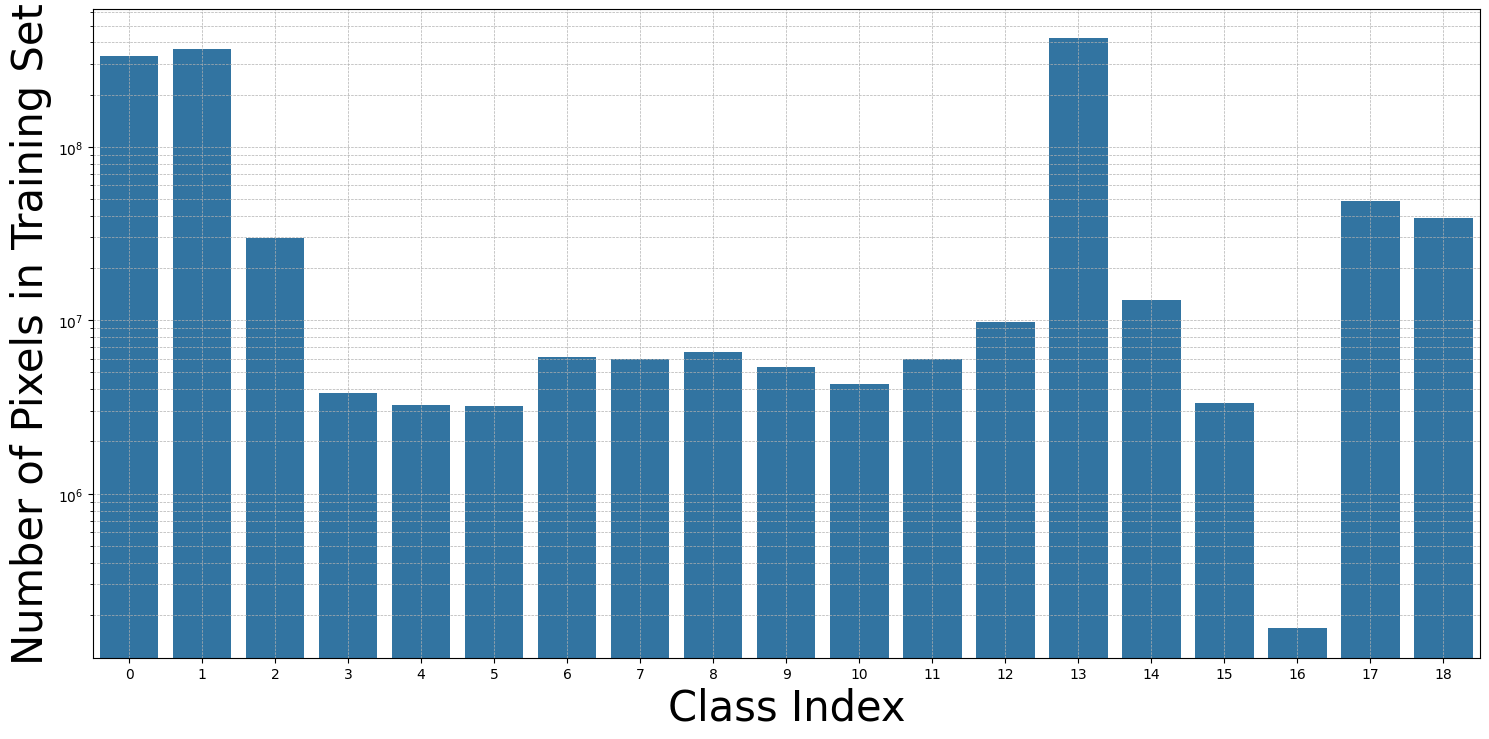

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert class distribution to frequencies (assuming class_distribution is defined)
class_frequencies = class_distribution.float()

# Create a plot
plt.figure(figsize=(15, 7.5))

# Plot using seaborn's barplot for better aesthetics
sns.barplot(x=np.arange(19), y=class_frequencies)

# Set y-axis to log10 scale
plt.yscale('log')

# Beautify the plot
plt.xlabel('Class Index', fontsize=30)
plt.ylabel('Number of Pixels in Training Set', fontsize=30)

# Add grid and style
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.xticks(np.arange(19))
plt.tight_layout()

# Save the plot with ppi=300
plt.savefig('class_frequency_distribution.png', dpi=300)

# Show the plot
plt.show()

Epoch 1/120:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 1/120: 100%|██████████| 2500/2500 [09:29<00:00,  4.39it/s]


Epoch 1/120, LR: 0.001000, Train Loss: 0.5526, Val Loss: 0.4112, Train mIoU: 43.76%, Val mIoU: 52.48%
Model saved at epoch 1, with val loss: 0.4112, val mIoU: 52.48%


Epoch 2/120: 100%|██████████| 2500/2500 [10:15<00:00,  4.06it/s]


Epoch 2/120, LR: 0.001000, Train Loss: 0.3755, Val Loss: 0.3673, Train mIoU: 56.11%, Val mIoU: 56.79%
Model saved at epoch 2, with val loss: 0.3673, val mIoU: 56.79%


Epoch 3/120: 100%|██████████| 2500/2500 [09:54<00:00,  4.21it/s]


Epoch 3/120, LR: 0.000998, Train Loss: 0.3317, Val Loss: 0.3184, Train mIoU: 59.62%, Val mIoU: 61.62%
Model saved at epoch 3, with val loss: 0.3184, val mIoU: 61.62%


Epoch 4/120: 100%|██████████| 2500/2500 [09:09<00:00,  4.55it/s]


Epoch 4/120, LR: 0.000996, Train Loss: 0.3013, Val Loss: 0.2974, Train mIoU: 62.31%, Val mIoU: 62.11%
Model saved at epoch 4, with val loss: 0.2974, val mIoU: 62.11%


Epoch 5/120: 100%|██████████| 2500/2500 [10:37<00:00,  3.92it/s]


Epoch 5/120, LR: 0.000992, Train Loss: 0.2885, Val Loss: 0.2881, Train mIoU: 63.58%, Val mIoU: 61.51%
Model saved at epoch 5, with val loss: 0.2881, val mIoU: 61.51%


Epoch 6/120: 100%|██████████| 2500/2500 [10:21<00:00,  4.02it/s]


Epoch 6/120, LR: 0.000988, Train Loss: 0.2696, Val Loss: 0.2845, Train mIoU: 65.06%, Val mIoU: 64.63%
Model saved at epoch 6, with val loss: 0.2845, val mIoU: 64.63%


Epoch 7/120: 100%|██████████| 2500/2500 [09:20<00:00,  4.46it/s]


Epoch 7/120, LR: 0.000982, Train Loss: 0.2566, Val Loss: 0.2694, Train mIoU: 65.94%, Val mIoU: 64.83%
Model saved at epoch 7, with val loss: 0.2694, val mIoU: 64.83%


Epoch 8/120: 100%|██████████| 2500/2500 [10:31<00:00,  3.96it/s]


Epoch 8/120, LR: 0.000976, Train Loss: 0.2467, Val Loss: 0.2582, Train mIoU: 66.84%, Val mIoU: 66.58%
Model saved at epoch 8, with val loss: 0.2582, val mIoU: 66.58%


Epoch 9/120: 100%|██████████| 2500/2500 [09:18<00:00,  4.47it/s]


Epoch 9/120, LR: 0.000969, Train Loss: 0.2367, Val Loss: 0.2556, Train mIoU: 67.41%, Val mIoU: 66.80%
Model saved at epoch 9, with val loss: 0.2556, val mIoU: 66.80%


Epoch 10/120: 100%|██████████| 2500/2500 [09:26<00:00,  4.42it/s]


Epoch 10/120, LR: 0.000961, Train Loss: 0.2285, Val Loss: 0.2662, Train mIoU: 68.03%, Val mIoU: 66.33%
Patience counter: 1/12


Epoch 11/120: 100%|██████████| 2500/2500 [13:21<00:00,  3.12it/s]


Epoch 11/120, LR: 0.000952, Train Loss: 0.2236, Val Loss: 0.2539, Train mIoU: 68.40%, Val mIoU: 67.25%
Model saved at epoch 11, with val loss: 0.2539, val mIoU: 67.25%


Epoch 12/120: 100%|██████████| 2500/2500 [12:37<00:00,  3.30it/s]


Epoch 12/120, LR: 0.000943, Train Loss: 0.2189, Val Loss: 0.2690, Train mIoU: 68.78%, Val mIoU: 66.03%
Patience counter: 1/12


Epoch 13/120: 100%|██████████| 2500/2500 [10:50<00:00,  3.85it/s]


Epoch 13/120, LR: 0.000932, Train Loss: 0.2139, Val Loss: 0.2486, Train mIoU: 69.24%, Val mIoU: 67.60%
Model saved at epoch 13, with val loss: 0.2486, val mIoU: 67.60%


Epoch 14/120: 100%|██████████| 2500/2500 [09:08<00:00,  4.55it/s]


Epoch 14/120, LR: 0.000921, Train Loss: 0.2077, Val Loss: 0.2374, Train mIoU: 69.61%, Val mIoU: 68.23%
Model saved at epoch 14, with val loss: 0.2374, val mIoU: 68.23%


Epoch 15/120: 100%|██████████| 2500/2500 [09:48<00:00,  4.25it/s]


Epoch 15/120, LR: 0.000909, Train Loss: 0.2031, Val Loss: 0.2360, Train mIoU: 70.05%, Val mIoU: 68.23%
Model saved at epoch 15, with val loss: 0.2360, val mIoU: 68.23%


Epoch 16/120: 100%|██████████| 2500/2500 [10:17<00:00,  4.05it/s]


Epoch 16/120, LR: 0.000897, Train Loss: 0.1982, Val Loss: 0.2366, Train mIoU: 70.32%, Val mIoU: 68.45%
Patience counter: 1/12


Epoch 17/120: 100%|██████████| 2500/2500 [08:02<00:00,  5.18it/s]


Epoch 17/120, LR: 0.000884, Train Loss: 0.1964, Val Loss: 0.2358, Train mIoU: 70.52%, Val mIoU: 67.96%
Model saved at epoch 17, with val loss: 0.2358, val mIoU: 67.96%


Epoch 18/120: 100%|██████████| 2500/2500 [09:32<00:00,  4.37it/s]


Epoch 18/120, LR: 0.000870, Train Loss: 0.1921, Val Loss: 0.2301, Train mIoU: 70.92%, Val mIoU: 68.71%
Model saved at epoch 18, with val loss: 0.2301, val mIoU: 68.71%


Epoch 19/120: 100%|██████████| 2500/2500 [14:56<00:00,  2.79it/s]


Epoch 19/120, LR: 0.000856, Train Loss: 0.1866, Val Loss: 0.2332, Train mIoU: 71.34%, Val mIoU: 68.33%
Patience counter: 1/12


Epoch 20/120: 100%|██████████| 2500/2500 [09:51<00:00,  4.23it/s]


Epoch 20/120, LR: 0.000842, Train Loss: 0.1842, Val Loss: 0.2370, Train mIoU: 71.48%, Val mIoU: 68.79%
Patience counter: 2/12


Epoch 21/120: 100%|██████████| 2500/2500 [11:16<00:00,  3.70it/s]


Epoch 21/120, LR: 0.000827, Train Loss: 0.1827, Val Loss: 0.2334, Train mIoU: 71.61%, Val mIoU: 69.54%
Patience counter: 3/12


Epoch 22/120: 100%|██████████| 2500/2500 [15:02<00:00,  2.77it/s]


Epoch 22/120, LR: 0.000812, Train Loss: 0.1785, Val Loss: 0.2320, Train mIoU: 72.07%, Val mIoU: 68.75%
Patience counter: 4/12


Epoch 23/120: 100%|██████████| 2500/2500 [08:05<00:00,  5.14it/s]


Epoch 23/120, LR: 0.000797, Train Loss: 0.1756, Val Loss: 0.2319, Train mIoU: 72.11%, Val mIoU: 69.37%
Patience counter: 5/12


Epoch 24/120: 100%|██████████| 2500/2500 [10:14<00:00,  4.07it/s]


Epoch 24/120, LR: 0.000781, Train Loss: 0.1740, Val Loss: 0.2309, Train mIoU: 72.34%, Val mIoU: 67.90%
Patience counter: 6/12


Epoch 25/120: 100%|██████████| 2500/2500 [09:09<00:00,  4.55it/s]


Epoch 25/120, LR: 0.000766, Train Loss: 0.1691, Val Loss: 0.2240, Train mIoU: 72.65%, Val mIoU: 69.33%
Model saved at epoch 25, with val loss: 0.2240, val mIoU: 69.33%


Epoch 26/120: 100%|██████████| 2500/2500 [10:25<00:00,  3.99it/s]


Epoch 26/120, LR: 0.000750, Train Loss: 0.1655, Val Loss: 0.2300, Train mIoU: 72.95%, Val mIoU: 69.22%
Patience counter: 1/12


Epoch 27/120: 100%|██████████| 2500/2500 [08:45<00:00,  4.76it/s]


Epoch 27/120, LR: 0.000734, Train Loss: 0.1652, Val Loss: 0.2215, Train mIoU: 72.90%, Val mIoU: 69.72%
Model saved at epoch 27, with val loss: 0.2215, val mIoU: 69.72%


Epoch 28/120: 100%|██████████| 2500/2500 [09:45<00:00,  4.27it/s]


Epoch 28/120, LR: 0.000719, Train Loss: 0.1611, Val Loss: 0.2261, Train mIoU: 73.23%, Val mIoU: 69.45%
Patience counter: 1/12


Epoch 29/120: 100%|██████████| 2500/2500 [14:07<00:00,  2.95it/s]


Epoch 29/120, LR: 0.000703, Train Loss: 0.1591, Val Loss: 0.2275, Train mIoU: 73.50%, Val mIoU: 70.12%
Patience counter: 2/12


Epoch 30/120: 100%|██████████| 2500/2500 [10:49<00:00,  3.85it/s]


Epoch 30/120, LR: 0.000688, Train Loss: 0.1587, Val Loss: 0.2284, Train mIoU: 73.44%, Val mIoU: 69.97%
Patience counter: 3/12


Epoch 31/120: 100%|██████████| 2500/2500 [11:43<00:00,  3.55it/s]


Epoch 31/120, LR: 0.000673, Train Loss: 0.1533, Val Loss: 0.2346, Train mIoU: 74.08%, Val mIoU: 69.32%
Patience counter: 4/12


Epoch 32/120: 100%|██████████| 2500/2500 [07:52<00:00,  5.29it/s]


Epoch 32/120, LR: 0.000658, Train Loss: 0.1521, Val Loss: 0.2311, Train mIoU: 74.20%, Val mIoU: 69.58%
Patience counter: 5/12


Epoch 33/120: 100%|██████████| 2500/2500 [08:44<00:00,  4.76it/s]


Epoch 33/120, LR: 0.000644, Train Loss: 0.1520, Val Loss: 0.2328, Train mIoU: 74.01%, Val mIoU: 70.26%
Patience counter: 6/12


Epoch 34/120: 100%|██████████| 2500/2500 [08:17<00:00,  5.02it/s]


Epoch 34/120, LR: 0.000630, Train Loss: 0.1490, Val Loss: 0.2389, Train mIoU: 74.37%, Val mIoU: 69.24%
Patience counter: 7/12


Epoch 35/120: 100%|██████████| 2500/2500 [08:00<00:00,  5.21it/s]


Epoch 35/120, LR: 0.000616, Train Loss: 0.1464, Val Loss: 0.2250, Train mIoU: 74.55%, Val mIoU: 70.14%
Patience counter: 8/12


Epoch 36/120: 100%|██████████| 2500/2500 [08:12<00:00,  5.08it/s]


Epoch 36/120, LR: 0.000603, Train Loss: 0.1452, Val Loss: 0.2358, Train mIoU: 74.69%, Val mIoU: 69.80%
Patience counter: 9/12


Epoch 37/120: 100%|██████████| 2500/2500 [11:00<00:00,  3.78it/s]


Epoch 37/120, LR: 0.000591, Train Loss: 0.1423, Val Loss: 0.2368, Train mIoU: 74.82%, Val mIoU: 69.40%
Patience counter: 10/12


Epoch 38/120: 100%|██████████| 2500/2500 [11:41<00:00,  3.56it/s]


Epoch 38/120, LR: 0.000579, Train Loss: 0.1417, Val Loss: 0.2272, Train mIoU: 74.93%, Val mIoU: 69.97%
Patience counter: 11/12


Epoch 39/120: 100%|██████████| 2500/2500 [12:52<00:00,  3.24it/s]
/tmp/ipykernel_3307245/124184933.py:182: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dic

Epoch 39/120, LR: 0.000568, Train Loss: 0.1391, Val Loss: 0.2413, Train mIoU: 75.23%, Val mIoU: 69.27%
Patience counter: 12/12
Patience reached at epoch 39, switching optimiser...
Switched to SGD optimiser with learning rate: 0.0200
Scheduler reset after switching to SGD optimizer.


Epoch 40/120: 100%|██████████| 2500/2500 [08:52<00:00,  4.70it/s]


Epoch 40/120, LR: 0.020000, Train Loss: 0.1523, Val Loss: 0.2201, Train mIoU: 74.01%, Val mIoU: 70.01%
Model saved at epoch 40, with val loss: 0.2201, val mIoU: 70.01%


Epoch 41/120: 100%|██████████| 2500/2500 [08:26<00:00,  4.94it/s]


Epoch 41/120, LR: 0.019961, Train Loss: 0.1485, Val Loss: 0.2224, Train mIoU: 74.31%, Val mIoU: 69.99%
Patience counter: 1/12


Epoch 42/120: 100%|██████████| 2500/2500 [08:35<00:00,  4.85it/s]


Epoch 42/120, LR: 0.019843, Train Loss: 0.1469, Val Loss: 0.2192, Train mIoU: 74.46%, Val mIoU: 69.84%
Model saved at epoch 42, with val loss: 0.2192, val mIoU: 69.84%


Epoch 43/120: 100%|██████████| 2500/2500 [08:32<00:00,  4.88it/s]


Epoch 43/120, LR: 0.019649, Train Loss: 0.1462, Val Loss: 0.2184, Train mIoU: 74.48%, Val mIoU: 70.10%
Model saved at epoch 43, with val loss: 0.2184, val mIoU: 70.10%


Epoch 44/120: 100%|██████████| 2500/2500 [08:52<00:00,  4.70it/s]


Epoch 44/120, LR: 0.019382, Train Loss: 0.1451, Val Loss: 0.2178, Train mIoU: 74.62%, Val mIoU: 70.35%
Model saved at epoch 44, with val loss: 0.2178, val mIoU: 70.35%


Epoch 45/120: 100%|██████████| 2500/2500 [09:34<00:00,  4.35it/s]


Epoch 45/120, LR: 0.019045, Train Loss: 0.1451, Val Loss: 0.2207, Train mIoU: 74.60%, Val mIoU: 70.05%
Patience counter: 1/12


Epoch 46/120: 100%|██████████| 2500/2500 [11:04<00:00,  3.76it/s]


Epoch 46/120, LR: 0.018645, Train Loss: 0.1442, Val Loss: 0.2214, Train mIoU: 74.71%, Val mIoU: 69.98%
Patience counter: 2/12


Epoch 47/120: 100%|██████████| 2500/2500 [09:23<00:00,  4.44it/s]


Epoch 47/120, LR: 0.018187, Train Loss: 0.1435, Val Loss: 0.2272, Train mIoU: 74.71%, Val mIoU: 70.07%
Patience counter: 3/12


Epoch 48/120: 100%|██████████| 2500/2500 [09:33<00:00,  4.36it/s]


Epoch 48/120, LR: 0.017679, Train Loss: 0.1449, Val Loss: 0.2200, Train mIoU: 74.56%, Val mIoU: 70.18%
Patience counter: 4/12


Epoch 49/120: 100%|██████████| 2500/2500 [09:49<00:00,  4.24it/s]


Epoch 49/120, LR: 0.017129, Train Loss: 0.1433, Val Loss: 0.2214, Train mIoU: 74.74%, Val mIoU: 70.29%
Patience counter: 5/12


Epoch 50/120: 100%|██████████| 2500/2500 [10:36<00:00,  3.93it/s]


Epoch 50/120, LR: 0.016545, Train Loss: 0.1427, Val Loss: 0.2208, Train mIoU: 74.89%, Val mIoU: 70.45%
Patience counter: 6/12


Epoch 51/120: 100%|██████████| 2500/2500 [08:48<00:00,  4.73it/s]


Epoch 51/120, LR: 0.015937, Train Loss: 0.1425, Val Loss: 0.2190, Train mIoU: 74.91%, Val mIoU: 70.60%
Patience counter: 7/12


Epoch 52/120: 100%|██████████| 2500/2500 [08:08<00:00,  5.11it/s]


Epoch 52/120, LR: 0.015314, Train Loss: 0.1417, Val Loss: 0.2215, Train mIoU: 74.95%, Val mIoU: 70.17%
Patience counter: 8/12


Epoch 53/120: 100%|██████████| 2500/2500 [08:19<00:00,  5.00it/s]


Epoch 53/120, LR: 0.014686, Train Loss: 0.1417, Val Loss: 0.2244, Train mIoU: 74.97%, Val mIoU: 70.25%
Patience counter: 9/12


Epoch 54/120: 100%|██████████| 2500/2500 [08:40<00:00,  4.81it/s]


Epoch 54/120, LR: 0.014063, Train Loss: 0.1415, Val Loss: 0.2213, Train mIoU: 74.84%, Val mIoU: 70.50%
Patience counter: 10/12


Epoch 55/120: 100%|██████████| 2500/2500 [08:00<00:00,  5.21it/s]


Epoch 55/120, LR: 0.013455, Train Loss: 0.1416, Val Loss: 0.2178, Train mIoU: 74.97%, Val mIoU: 70.71%
Model saved at epoch 55, with val loss: 0.2178, val mIoU: 70.71%


Epoch 56/120: 100%|██████████| 2500/2500 [08:24<00:00,  4.96it/s]


Epoch 56/120, LR: 0.012871, Train Loss: 0.1413, Val Loss: 0.2183, Train mIoU: 75.03%, Val mIoU: 70.42%
Patience counter: 1/12


Epoch 57/120: 100%|██████████| 2500/2500 [09:29<00:00,  4.39it/s]


Epoch 57/120, LR: 0.012321, Train Loss: 0.1409, Val Loss: 0.2244, Train mIoU: 75.07%, Val mIoU: 70.29%
Patience counter: 2/12


Epoch 58/120: 100%|██████████| 2500/2500 [11:35<00:00,  3.59it/s]


Epoch 58/120, LR: 0.011813, Train Loss: 0.1401, Val Loss: 0.2220, Train mIoU: 75.14%, Val mIoU: 70.49%
Patience counter: 3/12


Epoch 59/120: 100%|██████████| 2500/2500 [08:38<00:00,  4.82it/s]


Epoch 59/120, LR: 0.011355, Train Loss: 0.1409, Val Loss: 0.2210, Train mIoU: 75.02%, Val mIoU: 70.67%
Patience counter: 4/12


Epoch 60/120: 100%|██████████| 2500/2500 [10:38<00:00,  3.92it/s]


Epoch 60/120, LR: 0.010955, Train Loss: 0.1402, Val Loss: 0.2183, Train mIoU: 75.07%, Val mIoU: 70.64%
Patience counter: 5/12


Epoch 61/120: 100%|██████████| 2500/2500 [08:23<00:00,  4.97it/s]


Epoch 61/120, LR: 0.010618, Train Loss: 0.1406, Val Loss: 0.2220, Train mIoU: 75.05%, Val mIoU: 70.50%
Patience counter: 6/12


Epoch 62/120: 100%|██████████| 2500/2500 [08:13<00:00,  5.07it/s]


Epoch 62/120, LR: 0.010351, Train Loss: 0.1398, Val Loss: 0.2237, Train mIoU: 75.12%, Val mIoU: 70.41%
Patience counter: 7/12


Epoch 63/120: 100%|██████████| 2500/2500 [08:28<00:00,  4.92it/s]


Epoch 63/120, LR: 0.010157, Train Loss: 0.1401, Val Loss: 0.2200, Train mIoU: 75.07%, Val mIoU: 70.49%
Patience counter: 8/12


Epoch 64/120: 100%|██████████| 2500/2500 [08:15<00:00,  5.05it/s]


Epoch 64/120, LR: 0.010039, Train Loss: 0.1397, Val Loss: 0.2193, Train mIoU: 75.19%, Val mIoU: 70.45%
Patience counter: 9/12


Epoch 65/120: 100%|██████████| 2500/2500 [09:18<00:00,  4.48it/s]


Epoch 65/120, LR: 0.010000, Train Loss: 0.1400, Val Loss: 0.2201, Train mIoU: 75.13%, Val mIoU: 70.47%
Patience counter: 10/12


Epoch 66/120: 100%|██████████| 2500/2500 [11:33<00:00,  3.60it/s]


Epoch 66/120, LR: 0.010039, Train Loss: 0.1390, Val Loss: 0.2226, Train mIoU: 75.22%, Val mIoU: 70.37%
Patience counter: 11/12


Epoch 67/120: 100%|██████████| 2500/2500 [09:15<00:00,  4.50it/s]


Epoch 67/120, LR: 0.010157, Train Loss: 0.1393, Val Loss: 0.2212, Train mIoU: 75.16%, Val mIoU: 70.59%
Patience counter: 12/12
Patience reached at epoch 67, switching optimiser...
Switched to SGD optimiser with learning rate: 0.0100
Scheduler reset after switching to SGD optimizer.


Epoch 68/120: 100%|██████████| 2500/2500 [11:19<00:00,  3.68it/s]


Epoch 68/120, LR: 0.010000, Train Loss: 0.1411, Val Loss: 0.2206, Train mIoU: 75.07%, Val mIoU: 70.29%
Patience counter: 1/12


Epoch 69/120: 100%|██████████| 2500/2500 [08:29<00:00,  4.91it/s]


Epoch 69/120, LR: 0.009980, Train Loss: 0.1408, Val Loss: 0.2176, Train mIoU: 74.98%, Val mIoU: 70.62%
Model saved at epoch 69, with val loss: 0.2176, val mIoU: 70.62%


Epoch 70/120: 100%|██████████| 2500/2500 [08:05<00:00,  5.15it/s]


Epoch 70/120, LR: 0.009921, Train Loss: 0.1412, Val Loss: 0.2224, Train mIoU: 74.99%, Val mIoU: 70.58%
Patience counter: 1/12


Epoch 71/120: 100%|██████████| 2500/2500 [08:16<00:00,  5.04it/s]


Epoch 71/120, LR: 0.009824, Train Loss: 0.1400, Val Loss: 0.2222, Train mIoU: 75.18%, Val mIoU: 70.58%
Patience counter: 2/12


Epoch 72/120: 100%|██████████| 2500/2500 [08:12<00:00,  5.08it/s]


Epoch 72/120, LR: 0.009691, Train Loss: 0.1409, Val Loss: 0.2233, Train mIoU: 75.17%, Val mIoU: 70.51%
Patience counter: 3/12


Epoch 73/120: 100%|██████████| 2500/2500 [08:24<00:00,  4.95it/s]


Epoch 73/120, LR: 0.009523, Train Loss: 0.1403, Val Loss: 0.2184, Train mIoU: 75.15%, Val mIoU: 70.42%
Patience counter: 4/12


Epoch 74/120: 100%|██████████| 2500/2500 [08:32<00:00,  4.88it/s]


Epoch 74/120, LR: 0.009322, Train Loss: 0.1409, Val Loss: 0.2187, Train mIoU: 75.08%, Val mIoU: 70.53%
Patience counter: 5/12


Epoch 75/120: 100%|██████████| 2500/2500 [08:17<00:00,  5.03it/s]


Epoch 75/120, LR: 0.009094, Train Loss: 0.1402, Val Loss: 0.2226, Train mIoU: 75.11%, Val mIoU: 70.42%
Patience counter: 6/12


Epoch 76/120: 100%|██████████| 2500/2500 [08:32<00:00,  4.88it/s]


Epoch 76/120, LR: 0.008840, Train Loss: 0.1400, Val Loss: 0.2244, Train mIoU: 75.10%, Val mIoU: 70.23%
Patience counter: 7/12


Epoch 77/120: 100%|██████████| 2500/2500 [09:13<00:00,  4.52it/s]


Epoch 77/120, LR: 0.008564, Train Loss: 0.1395, Val Loss: 0.2198, Train mIoU: 75.13%, Val mIoU: 70.57%
Patience counter: 8/12


Epoch 78/120: 100%|██████████| 2500/2500 [09:22<00:00,  4.45it/s]


Epoch 78/120, LR: 0.008273, Train Loss: 0.1398, Val Loss: 0.2246, Train mIoU: 75.16%, Val mIoU: 70.37%
Patience counter: 9/12


Epoch 79/120: 100%|██████████| 2500/2500 [09:30<00:00,  4.38it/s]


Epoch 79/120, LR: 0.007968, Train Loss: 0.1398, Val Loss: 0.2231, Train mIoU: 75.08%, Val mIoU: 70.29%
Patience counter: 10/12


Epoch 80/120: 100%|██████████| 2500/2500 [09:22<00:00,  4.45it/s]


Epoch 80/120, LR: 0.007657, Train Loss: 0.1395, Val Loss: 0.2207, Train mIoU: 75.24%, Val mIoU: 70.35%
Patience counter: 11/12


Epoch 81/120: 100%|██████████| 2500/2500 [08:35<00:00,  4.85it/s]


Epoch 81/120, LR: 0.007343, Train Loss: 0.1391, Val Loss: 0.2217, Train mIoU: 75.34%, Val mIoU: 70.34%
Patience counter: 12/12
Patience reached at epoch 81, switching optimiser...
Switched to SGD optimiser with learning rate: 0.0050
Scheduler reset after switching to SGD optimizer.


Epoch 82/120: 100%|██████████| 2500/2500 [09:48<00:00,  4.25it/s]


Epoch 82/120, LR: 0.005000, Train Loss: 0.1406, Val Loss: 0.2206, Train mIoU: 75.15%, Val mIoU: 70.49%
Patience counter: 1/12


Epoch 83/120: 100%|██████████| 2500/2500 [09:30<00:00,  4.38it/s]


Epoch 83/120, LR: 0.004990, Train Loss: 0.1404, Val Loss: 0.2223, Train mIoU: 75.03%, Val mIoU: 70.53%
Patience counter: 2/12


Epoch 84/120: 100%|██████████| 2500/2500 [07:43<00:00,  5.40it/s]


Epoch 84/120, LR: 0.004961, Train Loss: 0.1405, Val Loss: 0.2208, Train mIoU: 75.04%, Val mIoU: 70.60%
Patience counter: 3/12


Epoch 85/120: 100%|██████████| 2500/2500 [07:53<00:00,  5.28it/s]


Epoch 85/120, LR: 0.004912, Train Loss: 0.1409, Val Loss: 0.2198, Train mIoU: 75.04%, Val mIoU: 70.49%
Patience counter: 4/12


Epoch 86/120: 100%|██████████| 2500/2500 [08:08<00:00,  5.12it/s]


Epoch 86/120, LR: 0.004845, Train Loss: 0.1400, Val Loss: 0.2197, Train mIoU: 75.09%, Val mIoU: 70.60%
Patience counter: 5/12


Epoch 87/120: 100%|██████████| 2500/2500 [07:56<00:00,  5.25it/s]


Epoch 87/120, LR: 0.004761, Train Loss: 0.1398, Val Loss: 0.2217, Train mIoU: 75.15%, Val mIoU: 70.38%
Patience counter: 6/12


Epoch 88/120: 100%|██████████| 2500/2500 [08:08<00:00,  5.12it/s]


Epoch 88/120, LR: 0.004661, Train Loss: 0.1395, Val Loss: 0.2227, Train mIoU: 75.07%, Val mIoU: 70.40%
Patience counter: 7/12


Epoch 89/120: 100%|██████████| 2500/2500 [08:02<00:00,  5.18it/s]


Epoch 89/120, LR: 0.004547, Train Loss: 0.1403, Val Loss: 0.2202, Train mIoU: 75.13%, Val mIoU: 70.63%
Patience counter: 8/12


Epoch 90/120: 100%|██████████| 2500/2500 [08:18<00:00,  5.01it/s]


Epoch 90/120, LR: 0.004420, Train Loss: 0.1401, Val Loss: 0.2226, Train mIoU: 75.17%, Val mIoU: 70.60%
Patience counter: 9/12


Epoch 91/120: 100%|██████████| 2500/2500 [08:07<00:00,  5.12it/s]


Epoch 91/120, LR: 0.004282, Train Loss: 0.1400, Val Loss: 0.2201, Train mIoU: 75.11%, Val mIoU: 70.56%
Patience counter: 10/12


Epoch 92/120: 100%|██████████| 2500/2500 [07:55<00:00,  5.26it/s]


Epoch 92/120, LR: 0.004136, Train Loss: 0.1399, Val Loss: 0.2210, Train mIoU: 75.24%, Val mIoU: 70.40%
Patience counter: 11/12


Epoch 93/120: 100%|██████████| 2500/2500 [08:05<00:00,  5.15it/s]


Epoch 93/120, LR: 0.003984, Train Loss: 0.1400, Val Loss: 0.2209, Train mIoU: 75.15%, Val mIoU: 70.43%
Patience counter: 12/12
Patience reached at epoch 93, switching optimiser...
SGD learning rate has dropped below the minimum threshold, stopping training.
Training finished. Best model loaded with val loss: 0.2176
Losses and mIoU saved to FastSCNN_lr_dynamic_batch_2_standard_scale_[1.0, 1.1]_colour_0.25_blur_0.03_linearup_weightedloss_wd_1e-7_losses.csv


/tmp/ipykernel_3307245/124184933.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Loss and mIoU curve figure saved to FastSCNN_lr_dynamic_batch_2_standard_scale_[1.0, 1.1]_colour_0.25_blur_0.03_linearup_weightedloss_wd_1e-7_losses.png


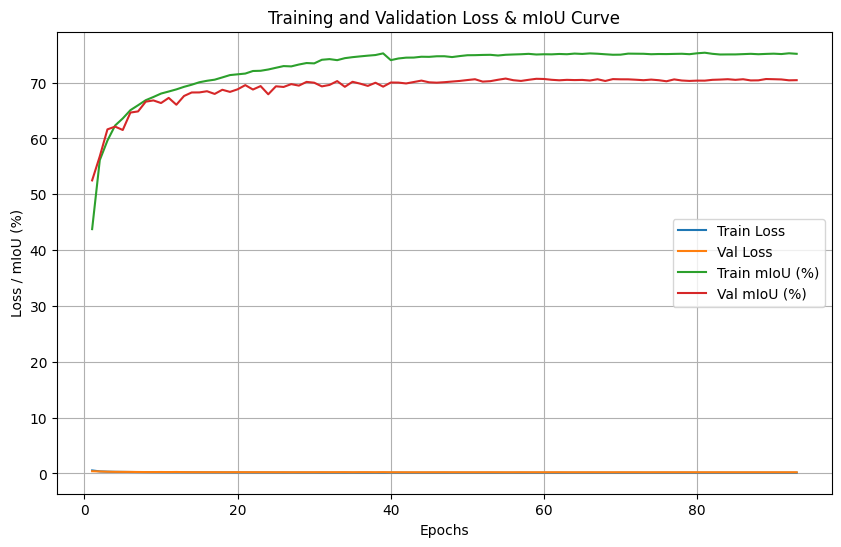

In [16]:
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import logging
import numpy as np

# Set up the log file path
log_file = model_name + 'training_output.log'

# If the file exists, delete it
if os.path.exists(log_file):
    os.remove(log_file)

# Set up logging to save the output to a new .txt file
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(message)s')

def log_message(message):
    print(message)  # Print the message to console
    logging.info(message)  # Save the message to the log file

def calculate_intersect_union(pred_mask, gt_mask, num_classes=19):
    area_intersect_all = np.zeros(num_classes)
    area_union_all = np.zeros(num_classes)
    
    for cls_idx in range(num_classes):
        area_intersect = np.sum((pred_mask == cls_idx) & (gt_mask == cls_idx))
        area_pred_label = np.sum(pred_mask == cls_idx)
        area_gt_label = np.sum(gt_mask == cls_idx)
        area_union = area_pred_label + area_gt_label - area_intersect

        area_intersect_all[cls_idx] += area_intersect
        area_union_all[cls_idx] += area_union

    return area_intersect_all, area_union_all

# Combined training function with dynamic learning rate switching, patience handling, and mIoU calculation
def train_dynamic(model, device, train_loader, val_loader, class_weights, initial_lr=0.001, min_sgd_lr=0.001, weight_decay=1e-6, scheduler_type='cosine', epochs=100, patience=10, checkpoint_path='best_model.pth', csv_file_name='losses.csv', load_weight=False, weight_path=None):
    # Define the loss function
    criterion = nn.CrossEntropyLoss(weight=class_weights)  # Multi-class segmentation loss

    # Start with Adam optimiser
    optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
    best_val_loss = float('inf')
    patience_counter = 0
    sgd_lr = 0.02  # Initial learning rate for SGD phase

        # Initialize scheduler
    if scheduler_type == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0.5 * initial_lr)
    elif scheduler_type == 'exponential':
        scheduler = ExponentialLR(optimizer, gamma=0.9)
    else:
        scheduler = None

    # Load pre-trained weights if specified
    if load_weight and weight_path:
        model.load_state_dict(torch.load(weight_path))
        log_message(f"Loaded weights from {weight_path}")

    # Lists to store train and validation losses and mIoU for each epoch
    train_losses, val_losses = [], []
    train_miou_list, val_miou_list = [], []



    for epoch in range(epochs):
        model.train()
        train_loss = 0

        
        # Initialize total intersection and union areas for the epoch
        total_area_intersect_train = np.zeros(19)
        total_area_union_train = np.zeros(19)

        # Training loop
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update train loss
            train_loss += loss.item()

            # Compute intersection and union for mIoU
            pred_masks = torch.argmax(outputs, dim=1).cpu().numpy()
            gt_masks = masks.cpu().numpy()
            
            for batch_idx in range(images.shape[0]):
                area_intersect, area_union = calculate_intersect_union(
                    pred_masks[batch_idx], gt_masks[batch_idx]
                )
                total_area_intersect_train += area_intersect
                total_area_union_train += area_union

        # Compute IoU for each class
        iou_per_class_train = total_area_intersect_train / (total_area_union_train + 1e-6)

        # Identify valid classes (those with at least one pixel in the union)
        valid_classes_train = total_area_union_train > 0

        # Compute mean IoU over valid classes
        train_miou = iou_per_class_train[valid_classes_train].mean() * 100

        # Validation loop
        model.eval()
        val_loss = 0
        # Initialize total intersection and union areas for validation
        total_area_intersect_val = np.zeros(19)
        total_area_union_val = np.zeros(19)

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Compute mIoU for validation
                pred_masks = torch.argmax(outputs, dim=1).cpu().numpy()
                gt_masks = masks.cpu().numpy()
                
                for batch_idx in range(images.shape[0]):
                    area_intersect, area_union = calculate_intersect_union(
                        pred_masks[batch_idx], gt_masks[batch_idx]
                    )
                    total_area_intersect_val += area_intersect
                    total_area_union_val += area_union

        val_loss /= len(val_loader)
        train_loss /= len(train_loader)

        # Save losses for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Compute IoU for each class
        iou_per_class_val = total_area_intersect_val / (total_area_union_val + 1e-6)

        # Identify valid classes (those with at least one pixel in the union)
        valid_classes_val = total_area_union_val > 0

        # Compute mean IoU over valid classes
        val_miou = iou_per_class_val[valid_classes_val].mean() * 100

        train_miou_list.append(train_miou)
        val_miou_list.append(val_miou)

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        log_message(f"Epoch {epoch+1}/{epochs}, LR: {current_lr:.6f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train mIoU: {train_miou:.2f}%, Val mIoU: {val_miou:.2f}%")

        # Update the learning rate using the scheduler at the end of each epoch
        scheduler.step()

        # Check for improvement in validation loss and save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter
            # Save model checkpoint
            torch.save(model.state_dict(), checkpoint_path)
            log_message(f"Model saved at epoch {epoch+1}, with val loss: {val_loss:.4f}, val mIoU: {val_miou:.2f}%")
        else:
            patience_counter += 1
            log_message(f"Patience counter: {patience_counter}/{patience}")

        # Early stopping and optimiser switch
        if patience_counter >= patience:
            log_message(f"Patience reached at epoch {epoch+1}, switching optimiser...")

            # Load the best model checkpoint before switching the optimiser
            model.load_state_dict(torch.load(checkpoint_path))

            # Switch to SGD optimiser with decreasing learning rate
            if sgd_lr >= min_sgd_lr:
                optimizer = optim.SGD(model.parameters(), lr=sgd_lr, weight_decay=weight_decay, momentum=0.5)
                log_message(f"Switched to SGD optimiser with learning rate: {sgd_lr:.4f}")

                # Reset the scheduler after switching the optimizer
                if scheduler_type == 'cosine':
                    scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min= 0.5 * sgd_lr)
                elif scheduler_type == 'exponential':
                    scheduler = ExponentialLR(optimizer, gamma=0.9)
        
                log_message(f"Scheduler reset after switching to SGD optimizer.")
                
                sgd_lr /= 2  # Halve the learning rate for the next phase
                patience_counter = 0  # Reset patience counter

                
            else:
                log_message("SGD learning rate has dropped below the minimum threshold, stopping training.")
                break  # Stop training if learning rate drops below minimum threshold

    # Load the best model weights after training
    model.load_state_dict(torch.load(checkpoint_path))
    log_message(f"Training finished. Best model loaded with val loss: {best_val_loss:.4f}")

    # Save train/val losses and mIoU to a CSV file
    loss_df = pd.DataFrame({
        'Epoch': range(1, len(train_losses) + 1),
        'Train Loss': train_losses,
        'Val Loss': val_losses,
        'Train mIoU (%)': train_miou_list,
        'Val mIoU (%)': val_miou_list
    })
    loss_df.to_csv(csv_file_name, index=False)
    log_message(f"Losses and mIoU saved to {csv_file_name}")

    # Plotting the train and validation loss and mIoU curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.plot(range(1, len(train_miou_list) + 1), train_miou_list, label='Train mIoU (%)')
    plt.plot(range(1, len(val_miou_list) + 1), val_miou_list, label='Val mIoU (%)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss / mIoU (%)')
    plt.title('Training and Validation Loss & mIoU Curve')
    plt.legend()
    plt.grid(True)

    # Save the figure
    plot_file_name = csv_file_name.replace('.csv', '.png')
    plt.savefig(plot_file_name)
    log_message(f"Loss and mIoU curve figure saved to {plot_file_name}")
    plt.show()

train_dynamic(model, device, train_loader, val_loader, class_weights, initial_lr=0.001, min_sgd_lr=0.005, weight_decay=1e-7, scheduler_type='cosine', epochs=120, patience=12, checkpoint_path=model_name + '_best.pth', csv_file_name=model_name + '_losses.csv')

In [17]:
model.load_state_dict(torch.load(model_name+'_best.pth'))

/tmp/ipykernel_3307245/2440697346.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name+'_best.pth'))


<All keys matched successfully>

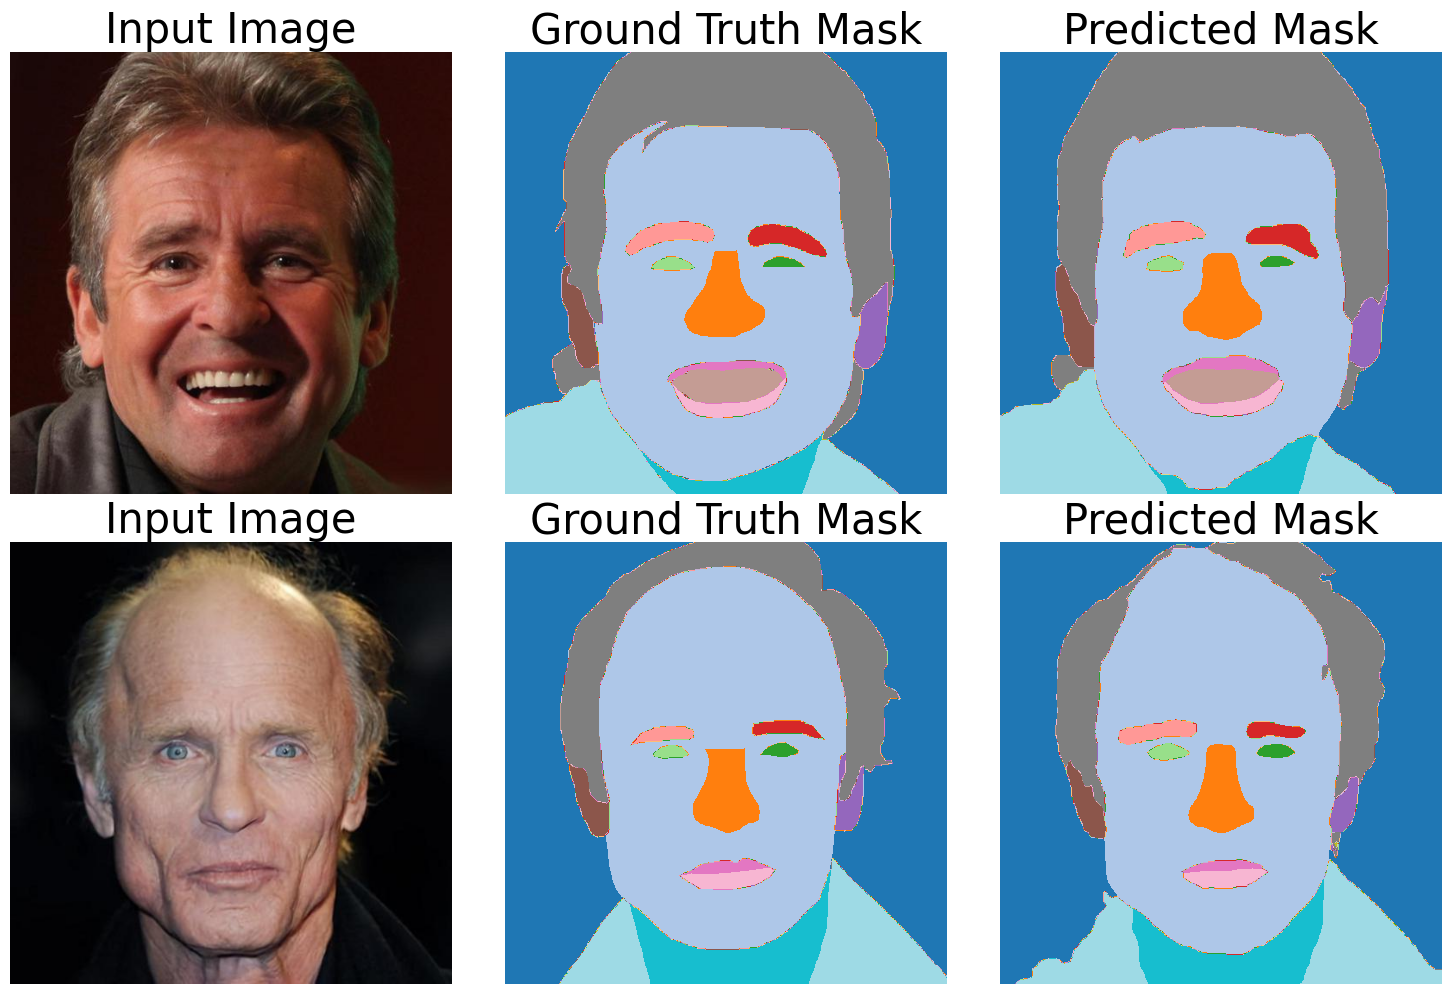

In [18]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def visualize_predictions(model, val_loader, device, image_folder='val/val_image', num_images=4):
    model.eval()
    model = model.to(device)

    images, masks = next(iter(val_loader))
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)

    # Ensure we do not exceed the number of images in the batch
    num_images = min(num_images, images.size(0))

    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))

    if num_images == 1:
        axes = [axes]  # Make sure axes is iterable when there's only 1 sample

    for i in range(num_images):
        # Load the original image from the folder (assuming filenames match the order in the val_loader)
        image_name = os.listdir(image_folder)[i]  # Get the ith image name from the folder
        image_path = os.path.join(image_folder, image_name)
        original_image = Image.open(image_path)

        # Show original image
        axes[i][0].imshow(original_image)  
        axes[i][0].set_title('Input Image', fontsize=30)  # Larger font size (2x larger)
        axes[i][0].axis('off')  # Turn off axis for the input image

        # Show ground truth mask
        axes[i][1].imshow(masks[i].cpu(), cmap='tab20', vmin=0, vmax=18)
        axes[i][1].set_title('Ground Truth Mask', fontsize=30)  # Larger font size (2x larger)
        axes[i][1].axis('off')  # Turn off axis for the ground truth mask

        # Convert output to predicted class indices
        pred_mask = torch.argmax(outputs[i], dim=0).cpu()  # (512, 512) mask with class labels
        axes[i][2].imshow(pred_mask, cmap='tab20', vmin=0, vmax=18)
        axes[i][2].set_title('Predicted Mask', fontsize=30)  # Larger font size (2x larger)
        axes[i][2].axis('off')  # Turn off axis for the predicted mask

    plt.tight_layout()
    plt.show()

# Visualize a few predictions
visualize_predictions(model, val_loader, device, num_images=10)

In [19]:
import os
import numpy as np
from PIL import Image
import torch



# Function to save a prediction mask as a PNG where pixel values are class labels
def save_prediction(pred_mask, original_filename, output_dir='prediction'):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Convert the tensor to a NumPy array
    pred_mask_np = pred_mask.cpu().numpy().astype(np.uint8)  # Ensure it's an 8-bit unsigned integer array
    
    # Save the NumPy array as a PNG image where pixel values are class labels
    pred_img = Image.fromarray(pred_mask_np)
    pred_img.save(os.path.join(output_dir, original_filename.replace('.jpg', '.png')))

# Function to iterate through validation dataset and save predictions
def save_predictions(model, val_loader, val_dataset, output_dir='prediction'):
    model.eval()
    model = model.cuda()

    # Iterate over the validation data loader
    for idx, (images, masks) in enumerate(val_loader):
        images = images.cuda()

        with torch.no_grad():
            outputs = model(images)

        # Get the corresponding filenames for this batch
        batch_filenames = val_dataset.images[idx * val_loader.batch_size : (idx + 1) * val_loader.batch_size]

        for i in range(images.size(0)):
            # Convert output to predicted class indices
            pred_mask = torch.argmax(outputs[i], dim=0)  # (512, 512) mask with class labels

            # Save the predicted mask with the original filename
            original_filename = batch_filenames[i]
            save_prediction(pred_mask, original_filename, output_dir)

# Call the function to save predictions
save_predictions(model, val_loader, val_dataset, output_dir=model_name+'prediction')

In [20]:
import os
import numpy as np
from PIL import Image


def read_masks(path):
    mask = Image.open(path)
    mask = np.array(mask)
    return mask


# replace submit_dir to your result path here
submit_dir = model_name + 'prediction'

# replace truth_dir to ground-truth path here
truth_dir = 'val/val_mask'

# replace output_dir to the desired output path, and you will find 'scores.txt' containing the calculated mIoU
output_dir = 'output'

if not os.path.isdir(submit_dir):
    print(f"{submit_dir} doesn't exist")

if os.path.isdir(submit_dir) and os.path.isdir(truth_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    submit_dir_list = os.listdir(submit_dir)
    if len(submit_dir_list) == 1:
        submit_dir = os.path.join(submit_dir, f"{submit_dir_list[0]}")
        assert os.path.isdir(submit_dir)

    # Class names based on the label list provided
    class_names = [
        'background', 'skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 
        'l_ear', 'r_ear', 'mouth', 'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 
        'neck_l', 'neck', 'cloth'
    ]

    area_intersect_all = np.zeros(19)
    area_union_all = np.zeros(19)
    
    for idx in range(1000):
        pred_mask = read_masks(os.path.join(submit_dir, f"{idx}.png"))
        gt_mask = read_masks(os.path.join(truth_dir, f"{idx}.png"))
        
        for cls_idx in range(19):
            area_intersect = np.sum(
                (pred_mask == gt_mask) * (pred_mask == cls_idx))

            area_pred_label = np.sum(pred_mask == cls_idx)
            area_gt_label = np.sum(gt_mask == cls_idx)
            area_union = area_pred_label + area_gt_label - area_intersect

            area_intersect_all[cls_idx] += area_intersect
            area_union_all[cls_idx] += area_union

    iou_all = area_intersect_all / area_union_all * 100.0
    miou = iou_all.mean()

    # Create the evaluation score path for mIOU
    output_filename = os.path.join(output_dir, model_name + 'scores.txt')
    with open(output_filename, 'w') as f3:
        f3.write(f'mIOU: {miou:.2f}%\n')

    # Write detailed IoU for each class to a separate file
    detailed_output_filename = os.path.join(output_dir, model_name + 'detailed_scores.txt')
    with open(detailed_output_filename, 'w') as f4:
        f4.write('Class-wise IoU scores:\n')
        for cls_idx in range(19):
            f4.write(f'{class_names[cls_idx]}: {iou_all[cls_idx]:.2f}%\n')
        f4.write(f'\nMean IoU (mIOU): {miou:.2f}%\n')

In [21]:
print(area_intersect_all)

[7.0791711e+07 6.2388127e+07 5.0054930e+06 5.4330600e+05 5.1070100e+05
 5.1342300e+05 9.0245900e+05 8.8520000e+05 9.4773200e+05 7.5881400e+05
 6.9190500e+05 9.3885400e+05 1.5815140e+06 7.8381534e+07 1.8786030e+06
 3.2820600e+05 3.0480000e+03 9.4099690e+06 6.8392940e+06]
